In [1]:
%config InlineBackend.figure_format = 'retina'

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
from scipy import sparse
import seaborn as sns

from cov import util, viz

sns.set(style="ticks", palette="tab10")

# load data and make adata object

Reanalysis of the data in [Durante et al. 2020](https://doi.org/10.1038/s41593-020-0587-9) to look for the expression of ACE2 and other SARS-CoV-2 related genes across cell types in the human respiratory and olfactory epithelium.

To run this notebook, first download the `GSE139522_RAW.tar` file from the NCBI GEO at [GSE139522](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE139522) and save it to the `data/raw` and then unzip it so you have a folder `data/raw/GSE139522_RAW`. The metadata with cluster annotations and UMAP embeddings is in the `data/tables` folder.

In [3]:
data_folds = util.get_data_folders()
raw_fold = util.get_raw_folders("human_OE")

In [4]:
df_meta = pd.read_csv(
    data_folds.tables / "GSE139522_Durante_Brann_covid_annotations_metadata.csv.gz",
    index_col=0,
)
df_meta.head()

,patient,cluster_name,total_counts,n_genes,ACE2,TMPRSS2,UMAP_1,UMAP_2
GSM4142873_Patient4_AAACCCAAGCATCGAG-1,Patient4,Circulating myeloid,2276.0,1090,0,1,-5.809517,14.731858
GSM4142873_Patient4_AAACCCACAGTTCTAG-1,Patient4,Early Resp. secretory,621.0,368,0,0,-5.933107,0.116086
GSM4142873_Patient4_AAACCCAGTAGCGCTC-1,Patient4,Resp. ciliated,13237.0,3807,0,1,4.984076,9.379796
GSM4142873_Patient4_AAACCCATCACCACAA-1,Patient4,Resp. HBC,6539.0,1981,0,0,3.673126,-8.421954
GSM4142873_Patient4_AAACGAACACTCCTGT-1,Patient4,Fibroblast,4875.0,1972,0,0,12.197668,0.631849


In [5]:
ad_fn = data_folds.processed / "Durante_human_OE.h5ad"
save = True
if ad_fn.exists():
    print("Loading h5ad file")
    adata = sc.read(ad_fn)
else:
    # load using scanpy; may take a while since the data on the GEO is the unfiltered mtx objects
    mtx_files = sorted(raw_fold.glob("*matrix.mtx.gz"))
    adatas = []
    for fn in mtx_files:
        prefix = fn.stem.split("matrix")[0]
        print(prefix)
        _ad = sc.read_10x_mtx(raw_fold, prefix=prefix, cache=True)
        _ad.obs_names = prefix + _ad.obs_names
        in_meta = _ad.obs_names.isin(df_meta.index)
        _ad_keep = _ad[in_meta].copy()
        adatas.append(_ad_keep)

    adata = adatas[0].concatenate(adatas[1:], index_unique=None, join="outer")
    assert adata.obs_names.isin(df_meta.index).all()
    assert df_meta.index.isin(adata.obs_names).all()
    adata.obs = adata.obs.join(df_meta.drop(columns=["ACE2", "TMPRSS2"]))
    adata.obsm["X_umap"] = adata.obs[["UMAP_1", "UMAP_2"]].values
    adata.raw = adata.copy()
    sc.pp.normalize_total(adata, target_sum=1e4)
    if save:
        print(f"Saving h5ad file to {ad_fn}")
        adata.write_h5ad(ad_fn)
print(adata)

Loading h5ad file
AnnData object with n_obs × n_vars = 33358 × 33538
    obs: 'batch', 'patient', 'cluster_name', 'total_counts', 'n_genes', 'UMAP_1', 'UMAP_2'
    var: 'gene_ids', 'feature_types'
    obsm: 'X_umap'


# plots

In [6]:
gen_clust_order = [
    "Olf. HBC",
    "OSN",
    "SUS",
    "Bowman's gland",
    "MV Brush-like",
    "MV Ionocyte-like",
    "Cycling Resp. HBC",
    "Resp. HBC",
    "Early Resp. secretory",
    "Resp. secretory",
    "Resp. ciliated",
    "Platelet",
    "B cell",
    "T cell",
    "NK cell",
    "Erythrocyte",
    "Mast cell",
    "Circulating myeloid",
    "OEC",
    "Fibroblast",
    "Pericyte/SMC",
    "Endothelial",
]

olf_clusts = [
    "Olf. HBC",
    "OSN",
    "SUS",
    "Bowman's gland",
    "MV Brush-like",
    "MV Ionocyte-like",
]
resp_clusts = [
    "Cycling Resp. HBC",
    "Resp. HBC",
    "Early Resp. secretory",
    "Resp. secretory",
    "Resp. ciliated",
]

cap = lambda s: s[:1].upper() + s[1:]
fix_str = lambda l, strs: [cap(s.replace(l, "")) for s in strs]

resp_label = fix_str("Resp. ", resp_clusts)
olf_label = fix_str("Olf. ", olf_clusts)

subset_order = olf_clusts + resp_clusts

remaining_order = [g for g in gen_clust_order if g not in subset_order]
col_dict = viz.make_color_dict(gen_clust_order)

(-14.5994911, 16.327341099999998, -17.11226945, 16.62399245)

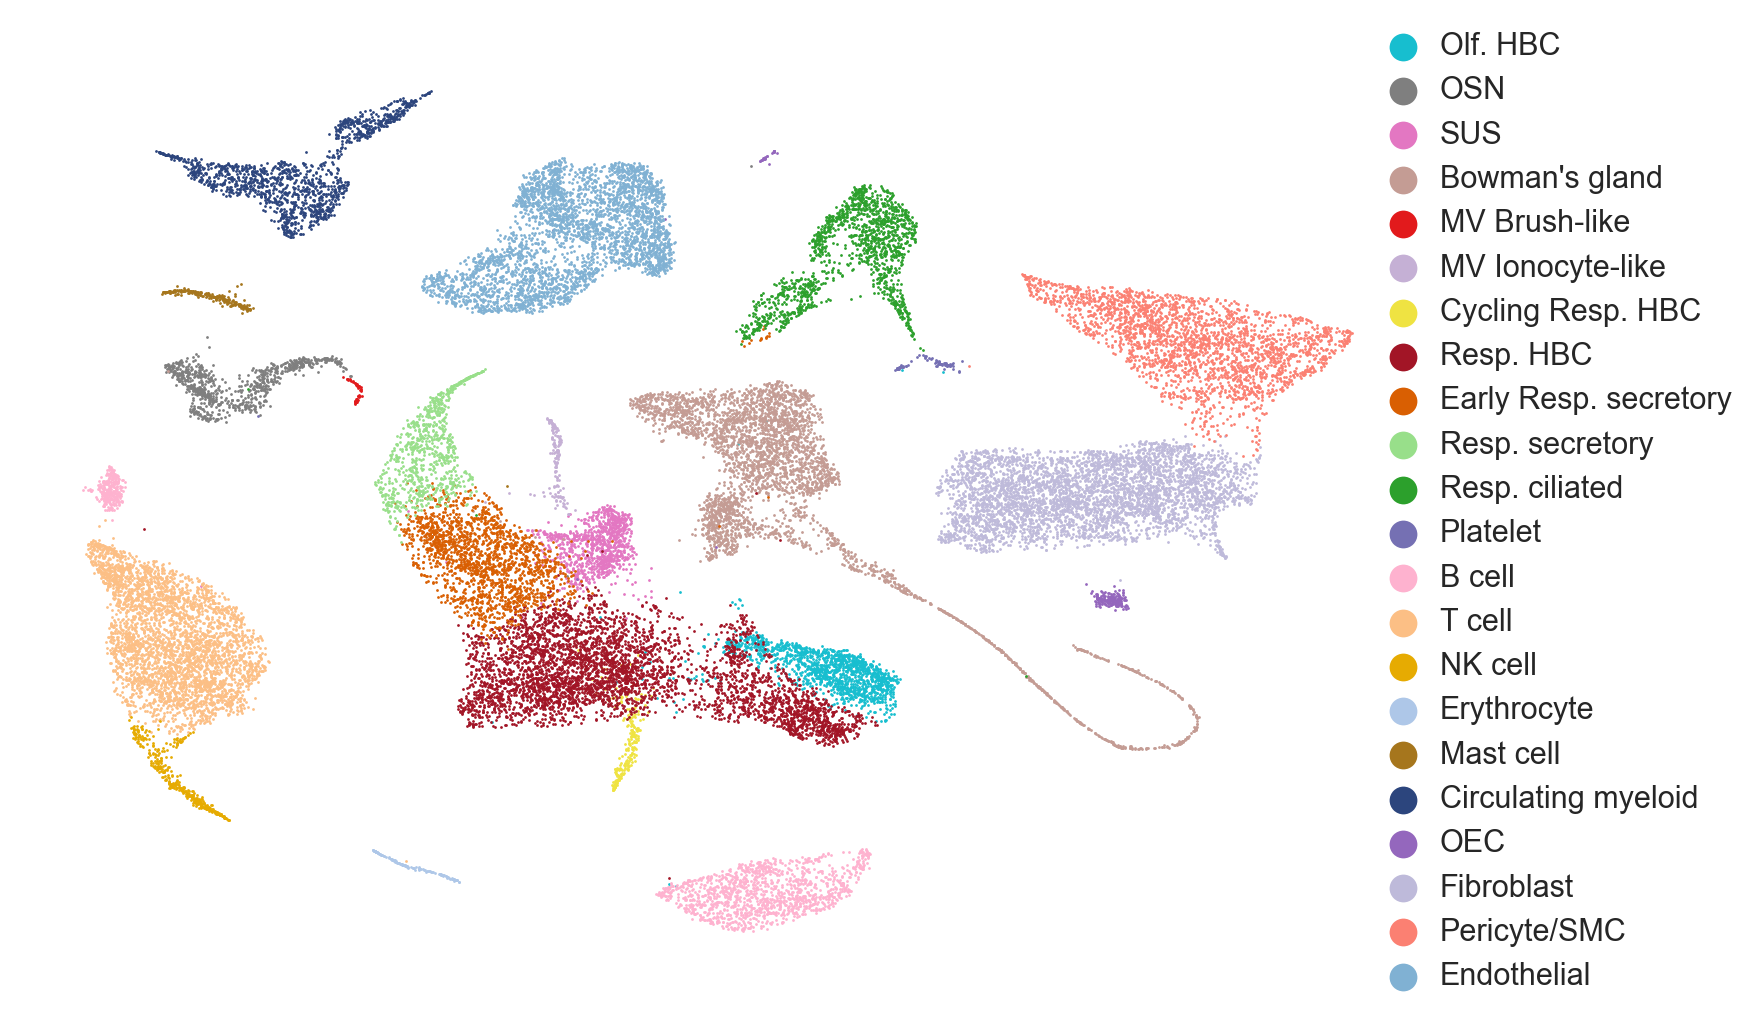

In [7]:
x, y = adata.obsm["X_umap"].T
fig, ax = plt.subplots(figsize=(9, 6))

for i, c in enumerate(gen_clust_order):
    is_cell = adata.obs.cluster_name == c
    this_x = x[is_cell]
    this_y = y[is_cell]
    ax.scatter(
        this_x, this_y, label=f"{c}", s=1, lw=0, color=col_dict[c], rasterized=True
    )

ax.legend(
    markerscale=10,
    ncol=1,
    loc="center left",
    bbox_to_anchor=(0.95, 0.5),
    columnspacing=0,
    frameon=False,
    handletextpad=0.2
)
ax.axis("off")

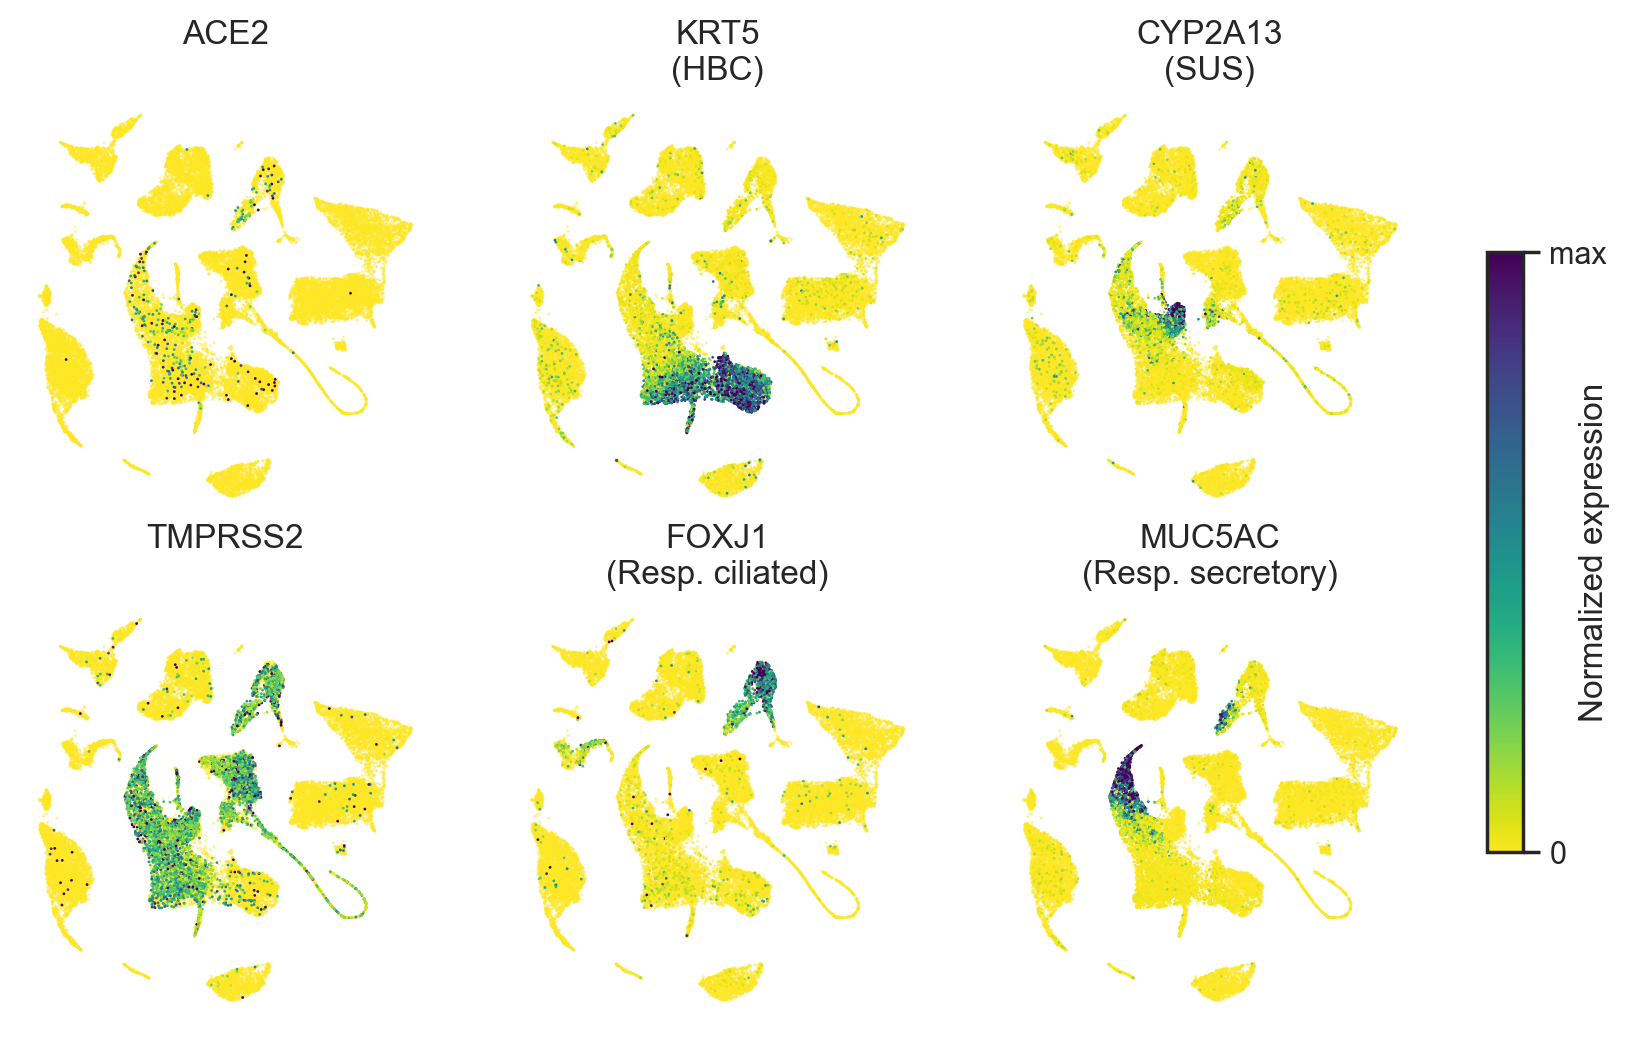

In [8]:
genes = [
    "ACE2",
    "KRT5",
    "CYP2A13",
    "TMPRSS2",
    "FOXJ1",
    "MUC5AC",
]
titles = [
    "ACE2\n",
    "KRT5\n(HBC)",
    "CYP2A13\n(SUS)",
    "TMPRSS2\n",
    "FOXJ1\n(Resp. ciliated)",
    "MUC5AC\n(Resp. secretory)",
]
df_resp = sc.get.obs_df(adata, genes)

fig, axes = plt.subplots(2, 3, figsize=(9, 6))
for i, (ax, gn, title) in enumerate(zip(axes.flatten(), genes, titles)):
    C = df_resp[gn]
    is_zero = C == 0
    vmax = np.percentile(C[C > 0], 95)
    if gn == "ACE2":
        vmax = 1
    ax.scatter(
        x[is_zero],
        y[is_zero],
        c=C[is_zero],
        s=1,
        cmap=plt.cm.viridis_r,
        vmin=0,
        vmax=vmax,
        lw=0,
        alpha=0.5,
        rasterized=True,
    )
    scatter = ax.scatter(
        x[~is_zero],
        y[~is_zero],
        c=C[~is_zero],
        s=1,
        cmap=plt.cm.viridis_r,
        vmin=0,
        vmax=vmax,
        lw=0,
        rasterized=True,
    )
    ax.set_axis_off()
    ax.set_title(title)
    if gn == "KRT5":
        viz.add_cbar(fig, scatter, pos=[0.94, 0.25, 0.02, 0.5])

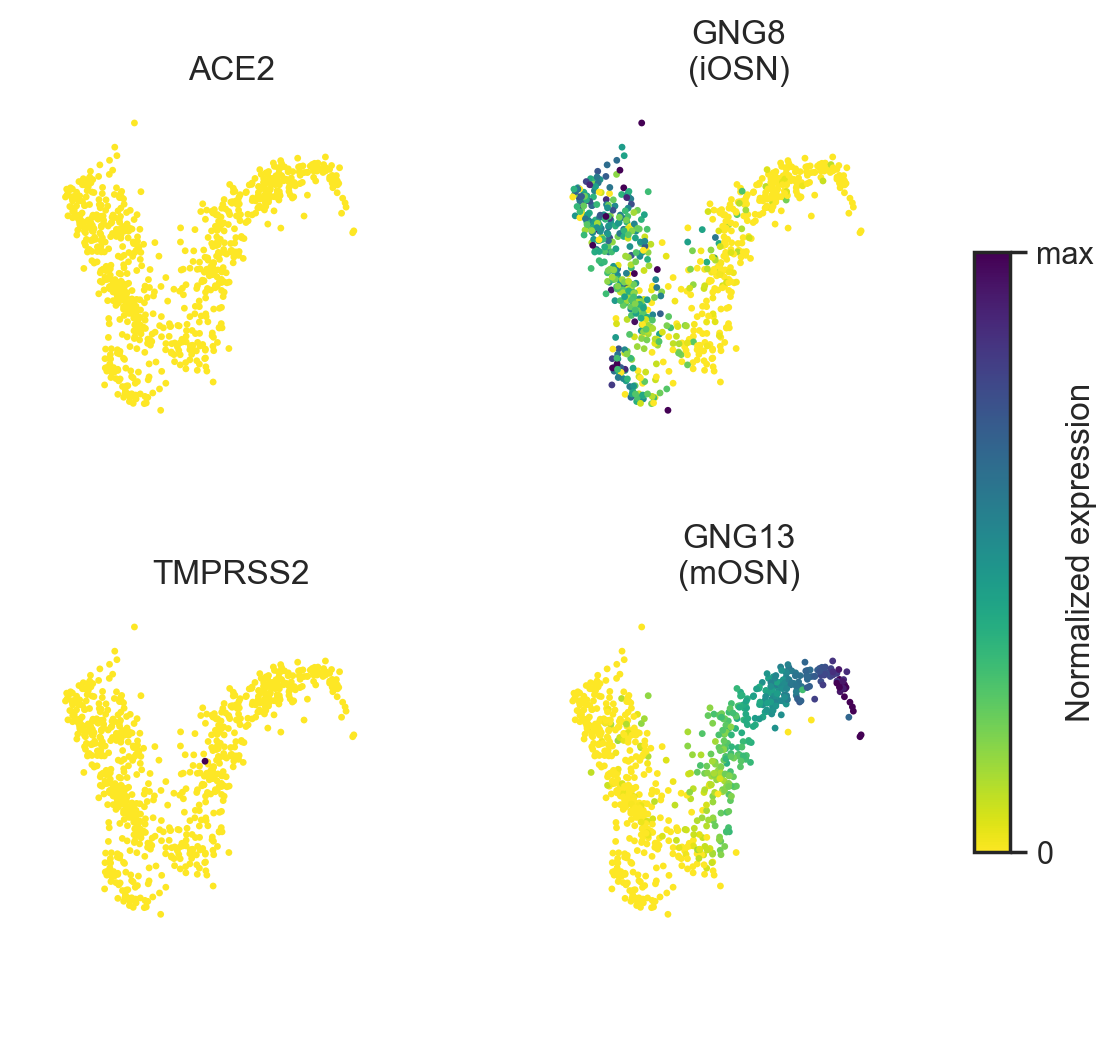

In [9]:
adata_osn = adata[(adata.obs.cluster_name == "OSN")].copy()
gns = ["ACE2", "GNG8", "TMPRSS2", "GNG13"]
df_osn = sc.get.obs_df(adata_osn, gns)


xo, yo = adata_osn.obsm["X_umap"].T
fig, axes = plt.subplots(2, 2, figsize=(6, 6))
for i, (ax, gn, title) in enumerate(
    zip(axes.flatten(), gns, ["ACE2", "GNG8\n(iOSN)", "TMPRSS2", "GNG13\n(mOSN)"])
):
    C = df_osn[gn]
    if C.max() > 0:
        vmax = np.percentile(C[C > 0], 97.5)
    else:
        vmax = 1
    scatter = ax.scatter(
        xo, yo, c=C, s=6, cmap="viridis_r", vmax=vmax, lw=0, rasterized=True
    )
    ax.set_xlim(None, -6)
    ax.set_ylim(2, 6)
    ax.set_axis_off()
    ax.set_title(title)
    if gn == "GNG13":
        viz.add_cbar(fig, scatter, pos=[0.92, 0.25, 0.03, 0.5])

In [10]:
genes_of_interest = [
    "CXCL14",
    "KRT5",
    "TP63",
    "GNG8",
    "CNGA2",
    "CYP2A13",
    "GPX3",
    "SOX9",
    "TRPM5",
    "ASCL3",
    "TOP2A",
    "SERPINB3",
    "MUC5AC",
    "FOXJ1",
]

cov_genes = [
    "ACE2",
    "TMPRSS2",
    "CTSB",
    "CTSL",
    "BSG",
    "HSPA5",
    "DPP4",
    "FURIN",
    "ANPEP",
    "TMPRSS11D",
    "ST6GAL1",
    "ST3GAL4",
    "CEACAM1",
]

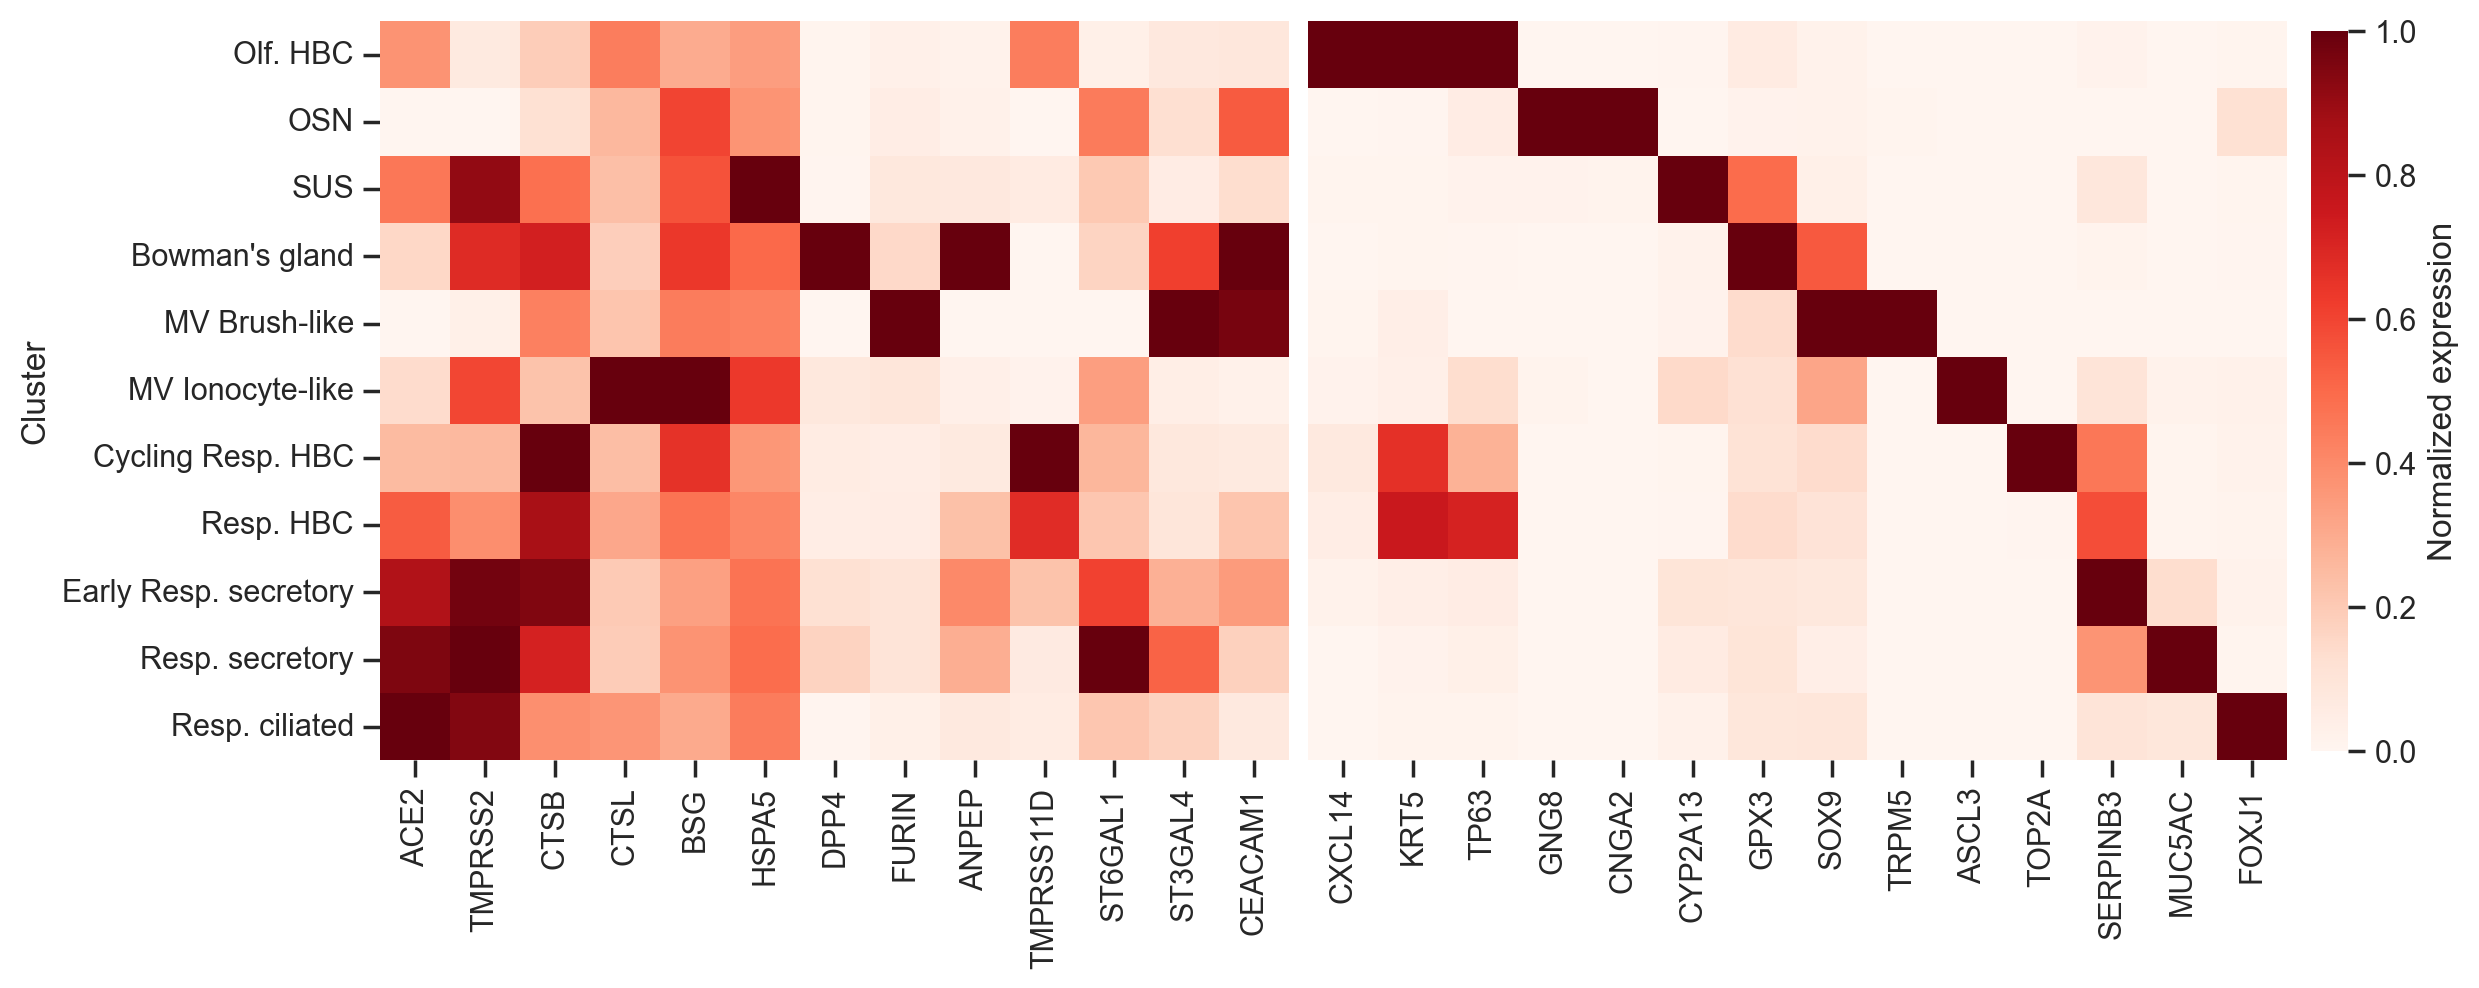

In [11]:
df_norm = viz.plot_heatmap(adata, genes_of_interest, cov_genes, subset_order)

,ACE2,TMPRSS2
cluster_name,,
B cell,0.000000,0.674433
Bowman's gland,0.462082,36.721935
Circulating myeloid,0.000000,0.886263
Cycling Resp. HBC,2.597403,22.510823
Early Resp. secretory,3.957038,47.936687
Endothelial,0.058005,0.986079
Erythrocyte,0.000000,0.000000
Fibroblast,0.023613,0.543093
MV Brush-like,0.000000,1.851852


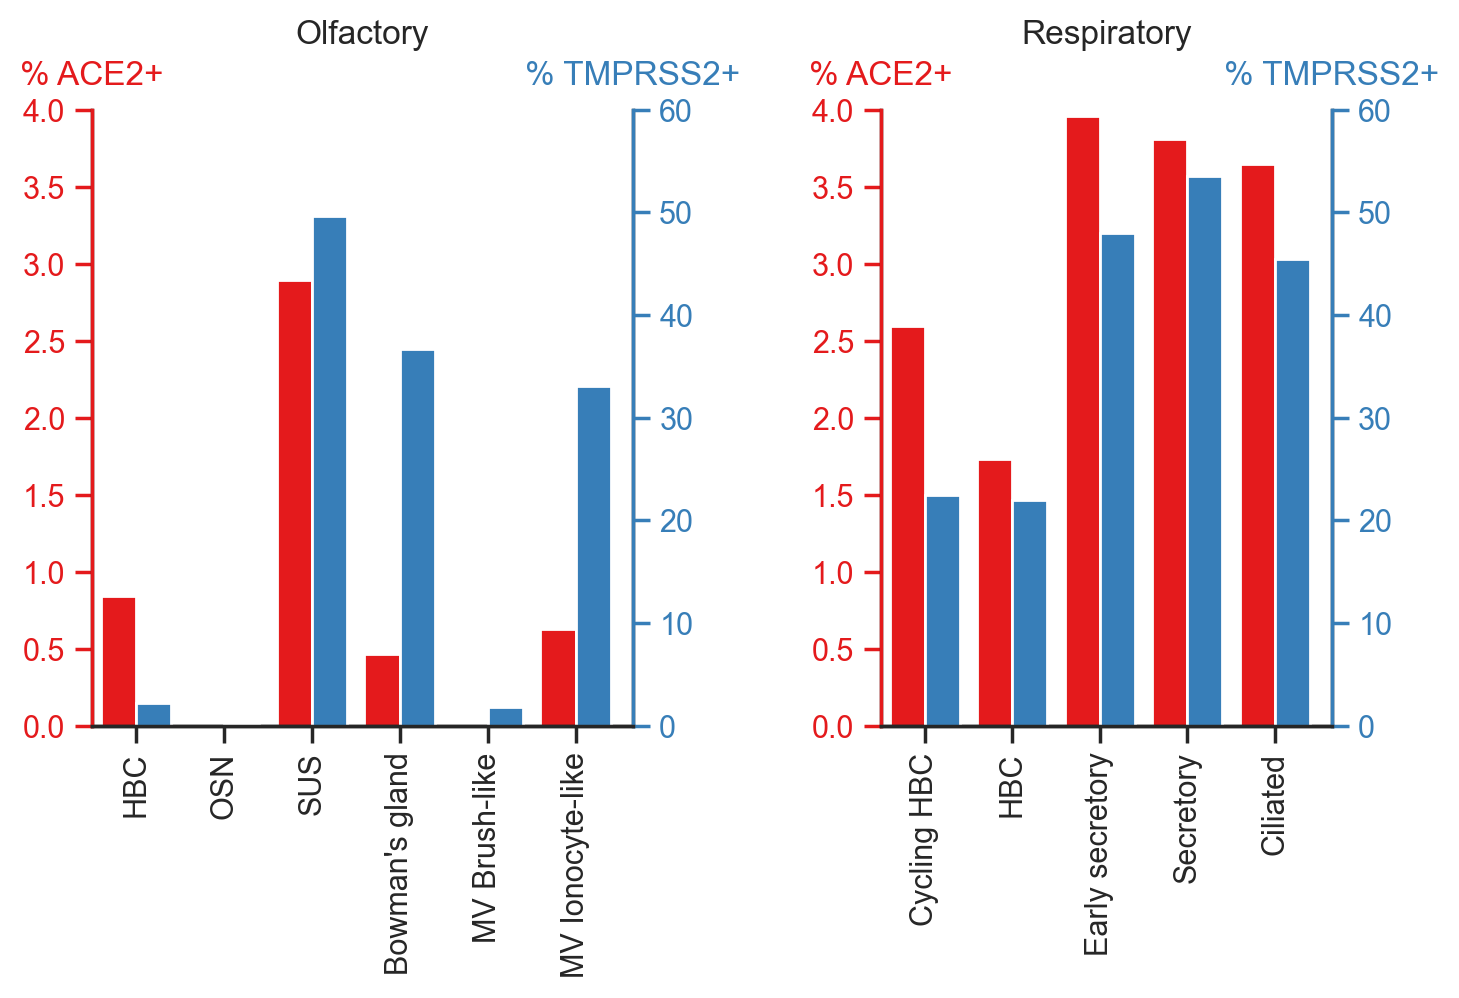

In [12]:
df_pct = viz.make_bar_plot(adata, (olf_clusts, resp_clusts), (olf_label, resp_label))
df_pct